# Estimation of effective connectivity (EC) using MOU process for model
## Replication of results from the paper by [M. Senden et al. (2017)](#references)
This Python notebook aims to reproduce the results presented in the abovementioned paper. As the fundamental approach utilized in the paper matches exactly the one applied in a closely related project by Gilson et al. (ct. [Notebook from Gilson et al. (2019)](#references)), the code is heavily influenced by and partly taken from this source. The class MOU (multivariate Ornstein-Uhlenbeck) from the [*pyMOU* library](#references) (pymou.mou_model), which is used in that project, was adapted to match the procedure described in the paper to be reproduced (slightly different process model). The changes exclusively effect the method fit_LO().

The files listed below are required to be positioned in the same location the main file *replicate_results_from_Senden_et_al_paper.ipynb* is located. 
- *mou_model.py* (The adapted version of the eponymous file from the [*pyMOU* library](#references).)
- *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables.)
- *BINARY_EC_MASK.mat* (Anatomical connectome averaged over subjects (structural data).)

In [1]:
## Import dependencies.
import os
import itertools
import scipy.io
import scipy.stats as stt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mou_model import MOU
%matplotlib inline

## Introduce constants.
_RES_DIR = 'model_parameter/'
_I_REST_RUN = 0
_I_NBACK_RUN = 1
_I_NO_TIMESHIFT = 0
_I_ONE_TIMESHIFT = 1
_SUBJECT_AXIS = 0

## Create a local folder to store results.
if not os.path.exists(_RES_DIR):
    print('created directory:', _RES_DIR)
    os.makedirs(_RES_DIR)

### Data set
The data set consists of 5 sessions for 14 subjects: one each for rest, the n-back task, the flanker task, the mental rotation task, and the odd-man out task. Each session is about 6 minutes long and consists of 192 time points (fMRI time resolution TR = 2 seconds). The parcellation corresponds to the Desikan-Killany (DK) atlas (Desikan et al., 2006; Klein & Tourville, 2012) with 68 regions of interest (ROIs).
The preprocessed fMRI data was downloaded from https://datadryad.org/stash/dataset/doi:10.5061/dryad.mc7pd. For more detailed information concerning the data follow the link above.

The data files are:
 - *DATA_TASK_3DMOV_HP_CSF_WD.mat* (BOLD time series (funtional data) and ROI lables)
 - *BINARY_EC_MASK.mat* (anatomical connectome averaged over subjects (structural data))

As the data format of the preprocessed data is different to the one in the aforementioned notebook by Gilson ([Notebooks from Gilson et al. (2019)](#references)), it is restructured to match the format of the latter for enhanced comparability.

In [2]:
## Read in data and structure it.
fMRI_data_and_labels = scipy.io.loadmat('DATA_TASK_3DMOV_HP_CSF_WD.mat')
regionalized_preprocessed_fMRI_data = fMRI_data_and_labels['TASKEC'][0][0]
roi_labels = fMRI_data_and_labels['ROIlbls'][0]
rest_run_data = regionalized_preprocessed_fMRI_data['Rest']
n_back_run_data = regionalized_preprocessed_fMRI_data['nBack']
flanker_run_data = regionalized_preprocessed_fMRI_data['Flanker']
m_rotation_run_data = regionalized_preprocessed_fMRI_data['mRotation']
odd_man_out_run_data = regionalized_preprocessed_fMRI_data['OddManOut']
# The fMRI data properties.
n_subjects = rest_run_data.shape[2]
n_runs = len(fMRI_data_and_labels['TASKEC'][0][0])
n_rois = rest_run_data.shape[1]
n_ts_samples = rest_run_data.shape[0]
# Restructure data.
filtered_ts_emp = np.zeros([n_subjects, n_runs, n_rois, n_ts_samples])
run = list(regionalized_preprocessed_fMRI_data.dtype.fields.keys())
for k in range(len(run)):
    filtered_ts_emp[:, k, :, :] = np.transpose(
        regionalized_preprocessed_fMRI_data[run[k]], (2, 1, 0))

### Functional connectivity (FC)
As the BOLD covariances are natural objective functions for the MOU model, they are used as  functional connectivity here. The BOLD time series are zero-centered in order to eliminate offset differences between runs.

Due to rescaling (rescale factor =  3.2268249232243638 ) most of the FC values should be between 0 and 1
Mean FC0 value: 0.13888774333316303 0.06411223364865776
Max FC0 value: 1.8585367462083686
Mean BOLD variance (diagonal of each FC0 matrix): 0.42634626903791756


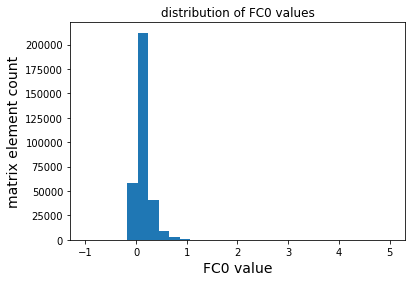

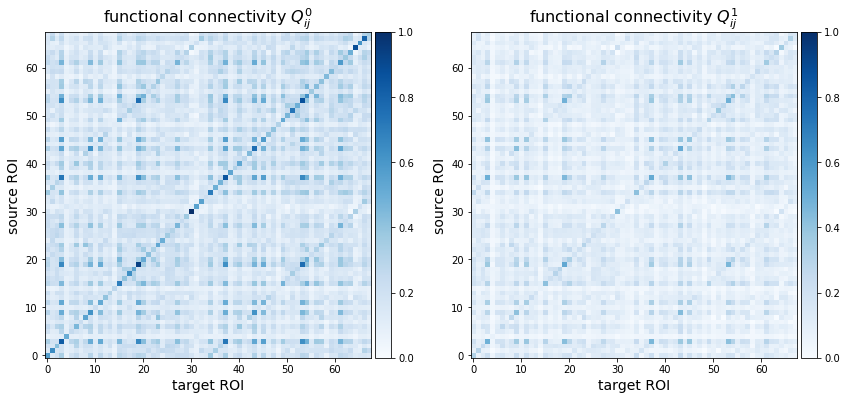

In [3]:
## Calculate functional connectivity (BOLD covariances) [Q0 and Q1].
time_shift = np.arange(4, dtype=float)
n_shifts = len(time_shift)

FC_emp = np.zeros([n_subjects, n_runs, n_shifts, n_rois, n_rois])
n_ts_span = n_ts_samples - n_shifts + 1
for i_subject in range(n_subjects):
    for i_run in range(n_runs):
        # Center the time series (around zero).
        filtered_ts_emp[i_subject, i_run, :, :] -=  \
                np.outer(filtered_ts_emp[i_subject, i_run, :, :].mean(1),
                         np.ones([n_ts_samples]))
        # Calculate covariances with various time shifts.
        for i_shift in range(n_shifts):
            FC_emp[i_subject, i_run, i_shift, :, :] = \
                np.tensordot(filtered_ts_emp[i_subject, i_run, :,
                                             0:n_ts_span],
                             filtered_ts_emp[i_subject, i_run, :,
                                             i_shift:n_ts_span + i_shift],
                             axes=(1, 1)) / float(n_ts_span - 1)

rescale_FC_factor = (0.5 / FC_emp[:, _I_REST_RUN, _I_NO_TIMESHIFT, :,
                                  :].diagonal(axis1=1, axis2=2).mean())
FC_emp *= rescale_FC_factor

print('Due to rescaling (rescale factor = ', rescale_FC_factor,
      ') most of the FC values should be between 0 and 1')
print('Mean FC0 value:', FC_emp[:, :, _I_NO_TIMESHIFT, :, :].mean(),
      FC_emp.mean())
print('Max FC0 value:', FC_emp[:, :, _I_NO_TIMESHIFT, :, :].max())
print('Mean BOLD variance (diagonal of each FC0 matrix):',
      FC_emp[:, :, _I_NO_TIMESHIFT, :, :].diagonal(axis1=2, axis2=3).mean())
# Show distibution of FC0 values.
plt.figure()
plt.hist(FC_emp[:, :, _I_NO_TIMESHIFT, :, :].flatten(),
         bins=np.linspace(-1, 5, 30))
plt.xlabel('FC0 value', fontsize=14)
plt.ylabel('matrix element count', fontsize=14)
plt.title('distribution of FC0 values')
# Show FC0 averaged over subjects for the rest run.
plt.figure(figsize=(14, 6))
plt.subplot(121)
FC_avg_over_subj = FC_emp[:, _I_REST_RUN,
                          _I_NO_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
ax = plt.gca()
im = ax.imshow(FC_avg_over_subj, origin='lower', cmap='Blues', vmax=1, vmin=0)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^0$', fontsize=16)
# Show FC1 averaged over subjects for the rest run.
plt.subplot(122)
FC_avg_over_subj = FC_emp[:, _I_REST_RUN,
                          _I_ONE_TIMESHIFT, :, :].mean(axis=_SUBJECT_AXIS)
ax = plt.gca()
im = ax.imshow(FC_avg_over_subj, origin='lower', cmap='Blues', vmax=1, vmin=0)
devider = make_axes_locatable(ax)
cax = devider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_xlabel('target ROI', fontsize=14)
ax.set_ylabel('source ROI', fontsize=14)
ax.set_title('functional connectivity $Q_{ij}^1$', fontsize=16)
plt.show()

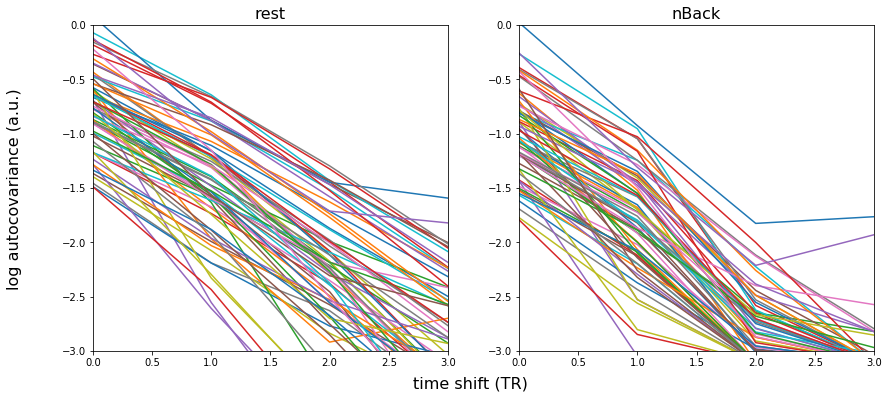

In [4]:
# Calculate the autocovariance. 
ac = FC_emp.diagonal(axis1=3, axis2=4)
# Show the autocovariance for the rest run.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.text(0.5, 0.04, 'time shift (TR)', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'log autocovariance (a.u.)', va='center', 
         rotation='vertical', fontsize=16)
plt.xlabel('time shift (TR)', fontsize=14)
plt.ylabel('log autocovariance (a.u.)', fontsize=14)
plt.subplot(121)
ac_avg_over_subj = np.log(np.maximum(ac[:, _I_REST_RUN, :, :].
                                     mean(axis=_SUBJECT_AXIS), np.exp(-4.0)))
plt.plot(range(n_shifts), ac_avg_over_subj)
plt.title('rest', fontsize=16)
plt.ylim((-3, 0))
plt.xlim((0, 3))
# Show the autocovariance for the nBack run.
plt.subplot(122)
ac_avg_over_subj = np.log(np.maximum(ac[:, _I_NBACK_RUN, :, :].
                                     mean(axis=_SUBJECT_AXIS), np.exp(-3.1)))
plt.plot(range(n_shifts), ac_avg_over_subj)
plt.title('nBack', fontsize=16)
plt.ylim((-3, 0))
plt.xlim((0, 3))
plt.show()

### Structural connectivity (SC)
The SC-matrix can be found at http://dutchconnectomelab.nl/ under the title 'Group-averaged binary connectivity matrix based on 50 healthy subjects. Data as used in the paper "Edge-centric perspective on the human connectome: link communities in the brain", De Reus et al. 2014, Philosophical Transactions of the Royal Society B. Oct 5;369(1653).' in the download section. Although this matrix is not the one used in the paper, it looks like the best alternative, for the paper does not provide a reference to the original matrix.

Typically, structural connectivity indicates '[...] the probability or the density of white-matter projections between pairs of ROIs in the parcellation. The algorithm that fits the model to the functional data (BOLD signals) only uses the information about whether there is a connection or not between two ROIs, to decide whether the corresponding weight is optimized.' ([Notebook from Gilson et al. (2019)](#references)) So, the downloaded binary matrix is completely sufficient for the purpose of reproducing the results from the abovementioned Senden paper.

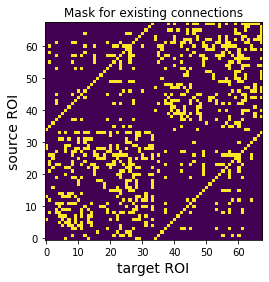

In [5]:
## Include structural connectivity.
# Load the binary structural connectivity matrix.
mask_EC = np.array(scipy.io.loadmat('BINARY_EC_MASK.mat')
                   ['grouped_umcu50_60percent'], dtype=bool)
# Enforce hermispheric connections.
for i in range(int(n_rois/2)):
    mask_EC[i, int(n_rois/2)+i] = True
    mask_EC[int(n_rois/2)+i, i] = True
# Visualise the binary structural connectivity mask.
plt.figure()
plt.imshow(mask_EC, origin='lower')
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('Mask for existing connections', fontsize=12)
plt.show()

### MOU-EC estimation
'The optimization procedure tunes the parameters of the MOU model, namely the directional connectivity ($C$, referred to as MOU-EC) and the input covariance ($\Sigma$). It is a gradient descent that aims to minimize the matrix distance between the model and empirical covariances (referred to as spatiotemporal FC). In practice, it is encapsulated in the *fit* method of the *MOU* class. For a tutorial of the use of the MOU class for simulation and estimation, check the *MOU_Simulation_Estimation* notebook.

The optimization algorithm works with learning rates for the connectivity and the input covariance ($\epsilon_C$ and $\epsilon_\Sigma$). If they are too fast, the fitting procedure may end up being stuck in a worse local minimum than what is achievable with smaller learning rates.' ([Notebook from Gilson et al. (2019)](#references)) In the paper (ct. [Senden et al. (2017)](#references)) $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ were chosen. For quicker but less finely graduated otimization try $\epsilon_C = 0.001$ and $\epsilon_\Sigma = 0.1$ with `mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T, mask_C=mask_EC, mask_Sigma=mask_Sigma, epsilon_C=0.001, epsilon_Sigma=0.1)`.

All parameters/restrictions not explicitly passed to the fit@MOU method, have the correct defaults in fit_LO@MOU.

Depending on the value of $\epsilon_C$ the following cell might take about 30 minutes ($\epsilon_C = 0.0001) and more to run through.

In [6]:
## Calculate EC-matrix.
# Construct diagonal mask for input noise matrix
# (here, no input cross-correlation).
mask_Sigma = np.eye(n_rois, dtype=bool)

# Run the model optimization.
# Initialize the source arrays.
# Jacobian (off-diagonal elements = EC)
J_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])
# Local variance (input covariance matrix, chosen to be diagonal)
Sigma_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])
# Model error
dist_mod = np.zeros([n_subjects, n_runs])
# Approximation of variance about the fitted data (FC covariance matrices)
R2_mod = np.zeros([n_subjects, n_runs])
# Between-region EC matrix
C_mod = np.zeros([n_subjects, n_runs, n_rois, n_rois])

mou_model = MOU()

for i_subject in range(n_subjects):
    for i_run in range(n_runs):
        # Run the estimation of model parameters, for all sessions.
        mou_model.fit(filtered_ts_emp[i_subject, i_run, :, :].T,
                      mask_Sigma=mask_Sigma, mask_C=mask_EC)
        # Organize the optimization results into arrays.
        # Extract Jacobian of the model.
        J_mod[i_subject, i_run, :, :] = mou_model.J
        # Extract noise (auto-)covariance matrix.
        Sigma_mod[i_subject, i_run, :, :] = mou_model.Sigma
        # Extract the matrix distance between the empirical objective
        # covariances and their model counterparts
        # (normalized for each objective matrix).
        dist_mod[i_subject, i_run] = mou_model.d_fit['distance']
        # The squared Pearson correlation is taken as an approximation
        # of the variance.
        R2_mod[i_subject, i_run] = mou_model.d_fit['correlation']**2
        # The between-region EC matrix of the model
        C_mod[i_subject, i_run, :, :] = mou_model.get_C()

        print('sub / run:', i_subject, i_run, ';\t model error, R2:',
              dist_mod[i_subject, i_run], R2_mod[i_subject, i_run])
        # Store the results in files.
np.save(_RES_DIR + 'FC_emp.npy',
        FC_emp)  # Empirical spatiotemporal FC
np.save(_RES_DIR + 'mask_EC.npy',
        mask_EC)  # Mask of optimized connections
np.save(_RES_DIR + 'mask_Sigma.npy',
        mask_Sigma)  # Mask of optimized Sigma elements
np.save(_RES_DIR + 'Sigma_mod.npy',
        Sigma_mod)  # Estimated Sigma matrices
np.save(_RES_DIR + 'dist_mod.npy',
        dist_mod)  # Model error
np.save(_RES_DIR + 'J_mod.npy',
        J_mod)  # Estimated Jacobian, EC + inverse time const. on diag.
print('\nFinished.')

sub / run: 0 0 ;	 model error, R2: 0.6613649951131519 0.5354706026787119
sub / run: 0 1 ;	 model error, R2: 0.6257431867736658 0.5213176961034771
sub / run: 0 2 ;	 model error, R2: 0.775534429052557 0.35561978626290053
sub / run: 0 3 ;	 model error, R2: 0.6311827720633116 0.5674853187241146
sub / run: 0 4 ;	 model error, R2: 0.6437573992751027 0.40164773406630633
sub / run: 1 0 ;	 model error, R2: 0.6478738269076777 0.4341833691083521
sub / run: 1 1 ;	 model error, R2: 0.6282468900653158 0.4678890853183252
sub / run: 1 2 ;	 model error, R2: 0.5887257041922025 0.6076042672051662
sub / run: 1 3 ;	 model error, R2: 0.6183220398096471 0.5336571532677988
sub / run: 1 4 ;	 model error, R2: 0.6410602075420702 0.5047799677449195
sub / run: 2 0 ;	 model error, R2: 0.7329259696266047 0.4499387781239495
sub / run: 2 1 ;	 model error, R2: 0.6918668886385648 0.4502244377648983
sub / run: 2 2 ;	 model error, R2: 0.7111033505885838 0.5461777932577153
sub / run: 2 3 ;	 model error, R2: 0.8144373244653

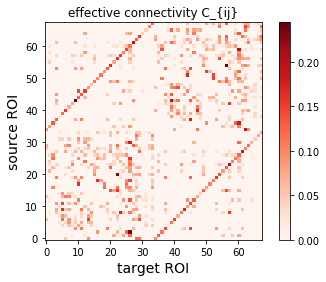

In [7]:
# Plot C-matrix for resting state data.
plt.figure()
plt.imshow(C_mod[:, _I_REST_RUN, :, :].mean(axis=_SUBJECT_AXIS),
           origin='lower', cmap='Reds')
plt.colorbar()
plt.xlabel('target ROI', fontsize=14)
plt.ylabel('source ROI', fontsize=14)
plt.title('effective connectivity C_{ij}')
plt.show()

### Local variability
As in the paper, local variability ($\Sigma$) is split up into the part exhibited by the rich club and the one exhibited by the peripheral regions.

In [8]:
## Calculate local variability for rich club and periphery.
mean_rc_var = np.zeros([n_runs])
mean_periph_var = np.zeros([n_runs])
conf_int_rc = np.zeros([n_runs, 2])
conf_int_periph = np.zeros([n_runs, 2])
# Create a 1D-mask for rich club regions.
mask_rc = np.zeros(n_rois, dtype=bool)
indexes_rich_club = [23, 26, 27, 57, 60, 61]
mask_rc[indexes_rich_club] = True
print('Rich club regions:\n'
      + str(np.concatenate(roi_labels[indexes_rich_club]).tolist()))

for i_run in range(n_runs):
    local_var = Sigma_mod[:, i_run, :, :].diagonal(axis1=1, axis2=2)
    rc_var = local_var[:, mask_rc].mean(axis=1)
    periph_var = local_var[:,  ~mask_rc].mean(axis=1)
    mean_rc_var[i_run] = rc_var.mean()
    mean_periph_var[i_run] = periph_var.mean()
    sigma_rc_var = rc_var.std(ddof=1)
    sigma_periph_var = periph_var.std(ddof=1)
    conf_int_rc[i_run, :] = stt.norm.interval(0.95,
                                              loc=mean_rc_var[i_run],
                                              scale=sigma_rc_var)
    conf_int_periph[i_run, :] = stt.norm.interval(0.95,
                                                  loc=mean_periph_var[i_run],
                                                  scale=sigma_periph_var)
print('Mean of local variability (rich club):\n' + str(mean_rc_var))
print('Mean of local variability (periphery):\n' + str(mean_periph_var))
print('95% confidence interval (rich cluc):\n' + str(conf_int_rc))
print('95% confidence interval (periphery):\n' + str(conf_int_periph))

Rich club regions:
['lh_precuneus', 'lh_superiorfrontal', 'lh_superiorparietal', 'rh_precuneus', 'rh_superiorfrontal', 'rh_superiorparietal']
Mean of local variability (rich club):
[0.04162144 0.04172214 0.03924228 0.04484446 0.04086206]
Mean of local variability (periphery):
[0.1490635  0.1541512  0.14432992 0.15982312 0.15312455]
95% confidence interval (rich cluc):
[[-0.00353375  0.08677664]
 [-0.02401059  0.10745488]
 [ 0.00033999  0.07814457]
 [-0.01679807  0.10648699]
 [-0.01839917  0.10012328]]
95% confidence interval (periphery):
[[0.03399635 0.26413065]
 [0.0238073  0.2844951 ]
 [0.08042015 0.20823969]
 [0.01257678 0.30706945]
 [0.02996566 0.27628344]]


### Input-output ratio
The information flow between regions is encapsulated in the $C$-matrix. In order to test the hypotheses that the rich club might gate the input it receives from peripheral regions, the inter-rich-club-connections are ignored. This means that only the information flow from and to the rich club is examined when it comes to the inspection of the rich club input-output-ratio.

In [9]:
## Calculate the input-output ratio.
# Create a 2D-mask for rich club regions.
mask_inter_rc = np.zeros([n_rois, n_rois], dtype=bool)
# The entries on the diagonal of C are 0 anyway, so that they can be
# ignored when it comes to the mask:
# mask_inter_rc[indexes_rich_club, indexes_rich_club] = True
rc_ind_combin = np.array(list(itertools.permutations(indexes_rich_club, 2))).T
mask_inter_rc[rc_ind_combin[0], rc_ind_combin[1]] = True

mean_rc_io = np.zeros([n_runs])
mean_periph_io = np.zeros([n_runs])
for i_run in range(n_runs):
    # Examine input-output ratio ignoring inter-rich-club connections.
    no_rc_connections_C = C_mod[:, i_run, :, :]
    no_rc_connections_C[:, mask_inter_rc] = 0
    roi_input = no_rc_connections_C[:, :, :].sum(axis=1)
    roi_output = no_rc_connections_C[:, :, :].sum(axis=2)
    io_rc = (roi_input[:, mask_rc].sum(axis=1) /
                              roi_output[:, mask_rc].sum(axis=1))
    io_periph = (roi_input[:, ~mask_rc].sum(axis=1) /
                               roi_output[:, ~mask_rc].sum(axis=1))
    mean_rc_io[i_run] = io_rc.mean()
    mean_periph_io[i_run] = io_periph.mean()


    sigma_io_rc = io_rc.std(ddof=1)
    sigma_io_periph = io_periph.std(ddof=1)
    conf_int_rc[i_run, :] = stt.norm.interval(0.95,
                                              loc=mean_rc_io[i_run],
                                              scale=sigma_io_rc)
    conf_int_periph[i_run, :] = stt.norm.interval(0.95,
                                                  loc=mean_periph_io[i_run],
                                                  scale=sigma_io_periph)
print('Mean input-output ratio rich club:\n', str(mean_rc_io))
print('Mean input-output ratio periphery:\n', str(mean_periph_io))
print('95% confidence interval (rich cluc):\n' + str(conf_int_rc))
print('95% confidence interval (periphery):\n' + str(conf_int_periph))


Mean input-output ratio rich club:
 [1.45458237 1.74728931 1.4695583  1.5416318  1.53145695]
Mean input-output ratio periphery:
 [0.9525185  0.9283904  0.94779527 0.94224823 0.9452756 ]
95% confidence interval (rich cluc):
[[0.60571173 2.30345301]
 [0.68763857 2.80694006]
 [0.86875921 2.07035739]
 [0.79958844 2.28367516]
 [0.84727784 2.21563605]]
95% confidence interval (periphery):
[[0.85991869 1.0451183 ]
 [0.85138255 1.00539824]
 [0.88996477 1.00562577]
 [0.87163049 1.01286597]
 [0.88413419 1.00641701]]


### References
<a id='references'></a>
Notebooks from Gilson et al. (2019): Andrea Insabato, Gorka Zamora-López, Matthieu Gilson 1_MOUEC_Estimation.ipynb. 2019. https://github.com/mb-BCA/notebooks_review2019/blob/master/1_MOUEC_Estimation.ipynb

Senden et al. (2017): M. Senden, N. Reuter, M. P. van den Heuvel, R. Goebel, G. Deco, and M. Gilson. Task-related effective connectivity reveals that the cortical rich club gates cortex-wide communication. Hum Brain Mapp, 2017. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23913

*pyMOU* library: Andrea Insabato, Gorka Zamora-López, Matthieu Gilson. 2019. https://github.com/mb-BCA/pyMOU 